# Assignment — Structural properties

In [1]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix

### Task 1. PageRank algorithm (0 points)

Implement PageRank algorithm. A function `page_rank` takes a graph `G`, transition coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.


In [2]:
'''Do not touch the cell'''
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Write a function `transition_matrix` that takes a np.array with an adjacency matrix `A` and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [4]:
def transition_matrix(A):
    ### BEGIN SOLUTION
    sumA = A.sum(axis=1)
    sumA[sumA == 0] = 1
    return A / sumA[:, None]
    ### END SOLUTION

In [5]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1

Write a function `teleportation_vector` that takes a np.array with an adjacency matrix `A` and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [7]:
def teleportation_vector(A):
    ### BEGIN SOLUTION
    return np.ones(A.shape[0]) / A.shape[0]
    ### END SOLUTION

In [8]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [9]:
def update_rank(rank, P, v, alpha):
    ### BEGIN SOLUTION
    return alpha * P.T @ rank + (1 - alpha) * v
    ### END SOLUTION

In [11]:
G = nx.path_graph(6, create_using=nx.DiGraph)
pr = page_rank(G, 0.9, 100)
assert np.all(pr[1:] - pr[:-1] > 0)

Let us draw the graph where node size depends on PageRank.

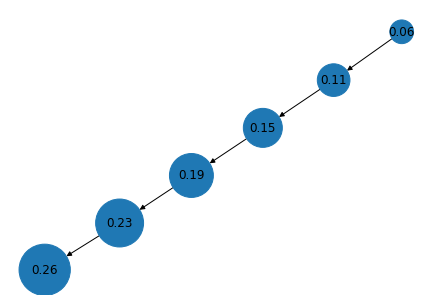

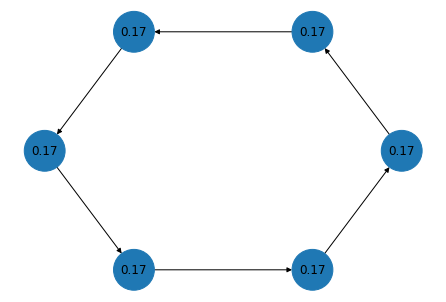

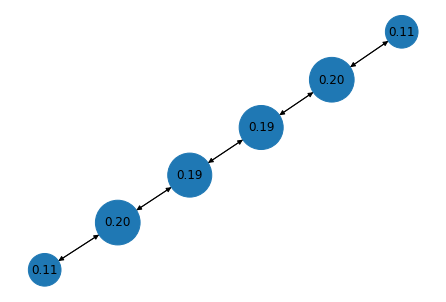

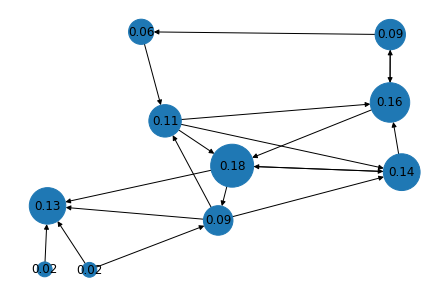

In [14]:
graphs = [
    nx.path_graph(6, create_using=nx.DiGraph),
    nx.cycle_graph(6, create_using=nx.DiGraph),
    nx.DiGraph(nx.path_graph(6)),
    nx.erdos_renyi_graph(10, 0.2, directed=True)
]
for G in graphs:
    pr = page_rank(G, 0.9, 100)
    nx.draw_kamada_kawai(
        G,
        with_labels=True,
        node_size=(pr * 1e4),
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)}
    )
    plt.show()

### Task 2. Personalized PageRank (3 points)

Personalized PageRank uses a teleportation vector as personal preferences, so that an important node has high probability to jump into it. Personalized PageRank can be considered as a simple recommender system. Consider a dataset of links between some famous painters on Wikipedia. Common PageRank gives us following ranks.

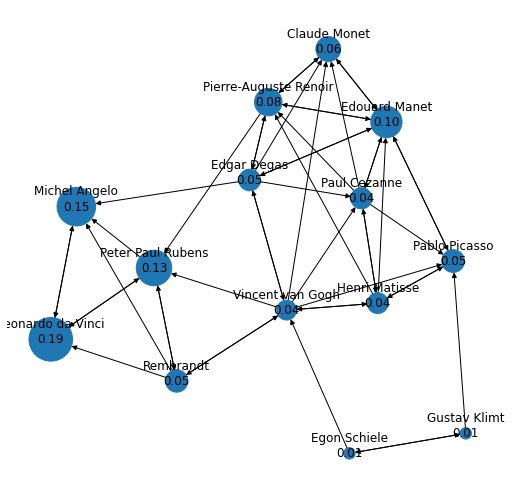

In [41]:
def plot_painters(G, pr, pref=None):
    if not pref:
        pref = []
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx(
        G, 
        pos, 
        node_size=(pr * 1e4),
        node_color=['tab:red' if G.nodes[n]['name'] in pref else 'tab:blue' for n in G.nodes],
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)})
    nx.draw_networkx_labels(
        G, 
        pos={node: pos[node] + [0, 0.05] for node in pos}, 
        labels=nx.get_node_attributes(G, 'name')
    )
    plt.axis('off')

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
pr = np.array([rank for node, rank in nx.pagerank(G, alpha=0.9).items()])
plt.figure(figsize=(9, 9))
plot_painters(G, pr)
plt.show()

Now let us calculate personalized PageRank based on user's preferences. Construct a teleportation vector so that painters a user likes are proportional to ones and others are zeros.

Write a function `personalized_pr` that takes an argument of common PageRank and a list `pref` that contains names of painters that user likes. The function returns personalized PageRank.

In [33]:
def personalized_pr(G, alpha, pref, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]


    attrs_inv = {value: key for key, value in nx.get_node_attributes(G, 'name').items()}
    
    v = np.zeros(A.shape[0])
    for pr in pref:
        v[attrs_inv[pr]] = 1 
        
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return np.array(rank / rank.sum())
    


In [37]:
pref = ['Pablo Picasso', 'Edgar Degas']
pr1 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
pref = ['Edgar Degas']
pr2 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
assert np.isclose(pr1.sum(), 1) and np.isclose(pr2.sum(), 1)
assert pr1[0] > pr2[0]
assert pr1[7] < pr2[7]

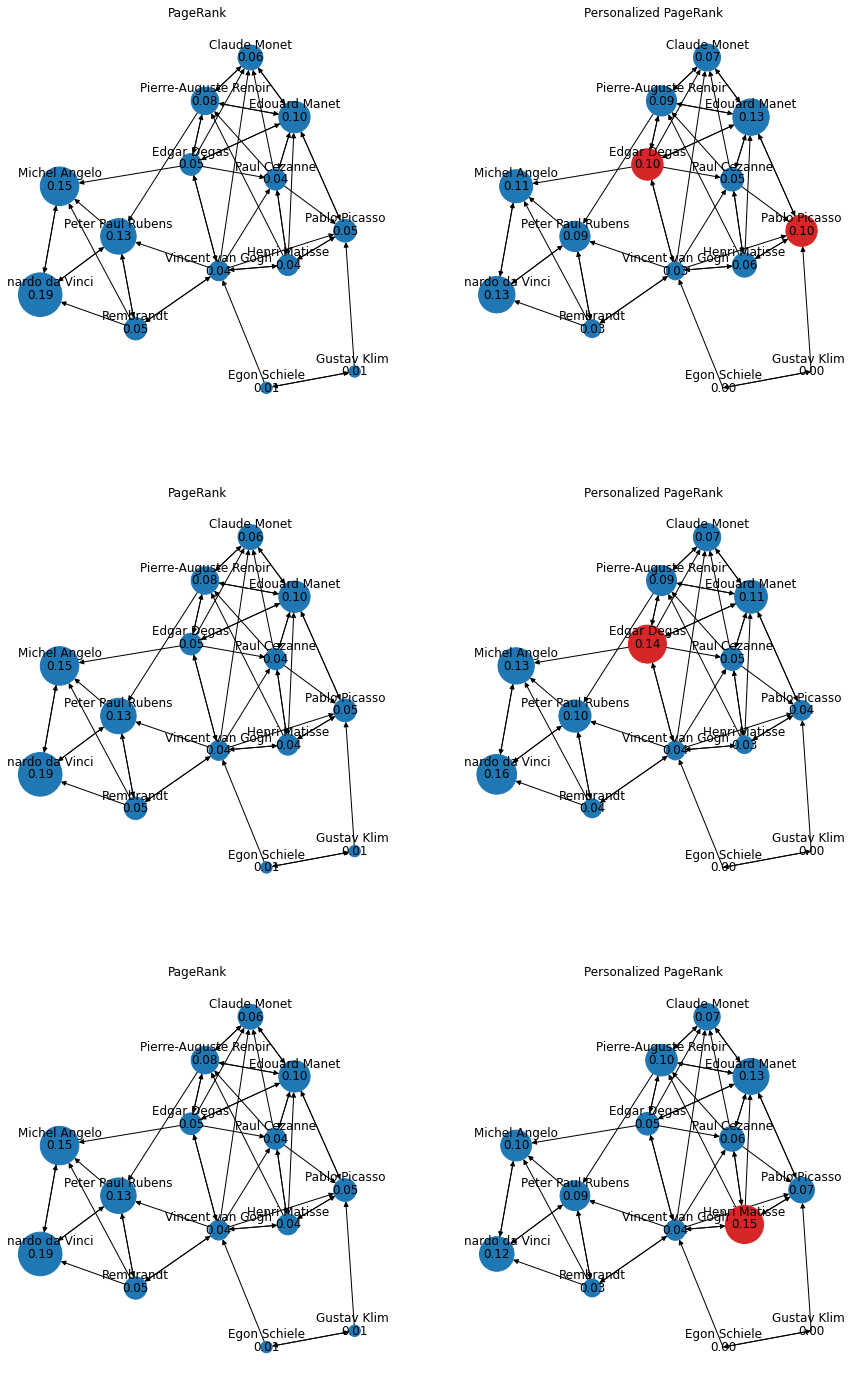

In [43]:
cases = [
    ['Pablo Picasso', 'Edgar Degas'], 
    ['Edgar Degas'], 
    ['Henri Matisse']
]
plt.figure(figsize=(15, 25))
for i, pref in enumerate(cases):
    plt.subplot(3, 2, i*2 + 1)
    plot_painters(G, pr)
    plt.title('PageRank')
    plt.subplot(3, 2, i*2 + 2)
    ppr = personalized_pr(G, alpha=0.9, pref=pref, k=100)
    plot_painters(G, ppr, pref)
    plt.title('Personalized PageRank')

Low transionion coefficient forces to teleport into prefferential nodes and vice versa, so we can adjust the power of preferences changing transionion coefficient.

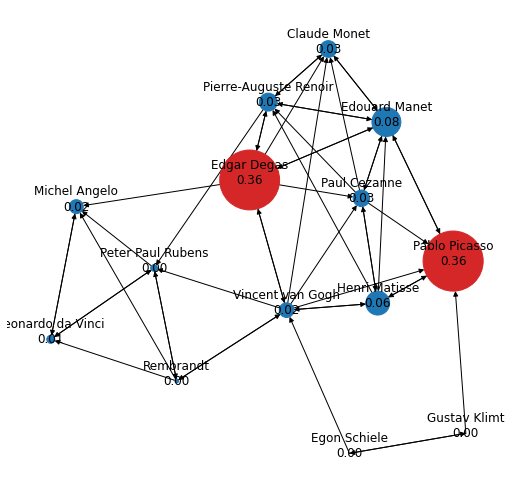

In [44]:
pref = ['Pablo Picasso', 'Edgar Degas']
alpha = 0.3
pr = personalized_pr(G, alpha=alpha, pref=pref, k=100)
plt.figure(figsize=(9, 9))
plot_painters(G, pr, pref)

### Task 3. PageRank visualization (3 points)

In this task we will visualize some properties of PageRank. First, we draw a plot where every line represents a PageRank of a node with respect to alpha while the number of iterations is fixed.

Write a function `rank_matrix_by_alpha` that takes a graph `G`, np.array of `alphas`, number of iterations `k` and returns a matrix of PageRank scores where alphas are rows and nodes are columns.

In [46]:
def rank_matrix_by_alpha(G, alphas, k):
    matrix = []
    for alpha in alphas: 
        matrix.append(page_rank(G, alpha, k))
    return np.array(matrix)

In [47]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
alpha_space = np.linspace(0.1, 0.95, 100)
ranks = rank_matrix_by_alpha(G, alpha_space, 100)
assert ranks.shape == (100, 14)
assert ranks[-1, 0] < ranks[0, 0] < 0.08
assert ranks[0, 7] > ranks[-1, 7] > 0.02

Now write a function `node_color` that takes a `node` and np.array with PageRank scores `rank`. The length of `rank` is the number of nodes and `rank[node]` is a score of a node. Also here are two colors:
* `start_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]
* `end_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]

The function is a linear mapping from an _index_ (not score) of a node in sorted PageRank to a RGB color, that is the lowest index is a start color and the largest index is an end color. 

_For example, if a start color is [1, 1, 1], end color is [0, 0, 0] and PageRank of nodes are_
* 0: 0.1
* 1: 0.2
* 2: 0.7

_then the mapping of node 1 will be [0.5, 0.5, 0.5]._

The function returns a np.array of RGB color.

In [137]:
def node_color(node, rank, start_rgb, end_rgb):
    x0, y0, z0 = start_rgb
    x1, y1, z1 = end_rgb

    n = len(sorted(rank))
    sorted_pairs = sorted([(rk, i) for i, rk in enumerate(rank)], key=lambda x: x[0])
    indices = [j for i, j in sorted_pairs]
    index = indices.index(node)

    xs = np.linspace(x0, x1, n, endpoint=True)
    ys = np.linspace(y0, y1, n, endpoint=True)
    zs = np.linspace(z0, z1, n, endpoint=True)
    
    return  np.array([xs[index], ys[index], zs[index]])

In [138]:
rank = np.array([0.1, 0.2, 0.7])
start_rgb, end_rgb = np.array([1, 1, 1]), np.array([0, 0, 0])
temp_rgb = node_color(1, rank, start_rgb, end_rgb)
assert temp_rgb.shape == (3,)
assert 0 <= temp_rgb.sum() <= 3
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0.5
temp_rgb = node_color(0, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 1
temp_rgb = node_color(2, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0
start_rgb = np.array([231, 76, 60]) / 255
end_rgb = np.array([46, 204, 113 ]) / 255
assert round(node_color(0, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.432
assert round(node_color(1, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.4271

Let us draw PageRank of nodes by alpha. Node with the lowest PageRank will be red, the largest — green, and others will spread between them.

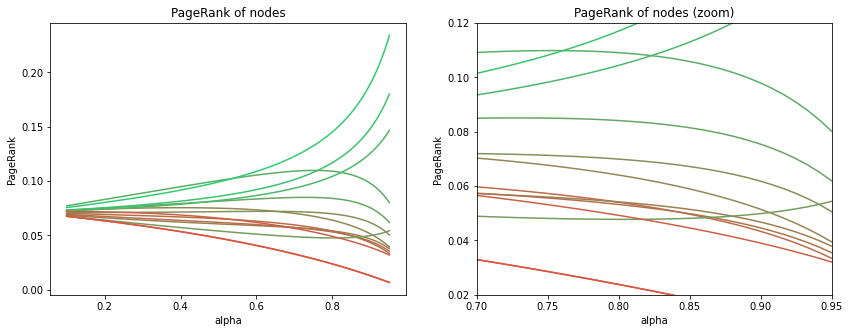

In [139]:
plt.figure(figsize=(14, 5))

cases = [[1, None, None, None, None, 'PageRank of nodes'], 
         [2, 0.7, 0.95, 0.02, 0.12, 'PageRank of nodes (zoom)']]

for i, x_min, x_max, y_min, y_max, t in cases:
    plt.subplot(1, 2, i)
    for idx, node in enumerate(G.nodes):
        plt.plot(
            alpha_space, 
            ranks[:, idx], 
            color=node_color(idx, ranks[-1], start_rgb, end_rgb)
        )
    plt.xlabel('alpha')
    plt.ylabel('PageRank')
    plt.title(t)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

We can observe that reds are going down, greens going up, but some intermediate nodes change the direction near alpha 0.7. Next, let us draw a similar plot — PageRank of nodes with respect to number of iterations while alpha is fixed.

Write a function `rank_matrix_by_alpha` that takes a graph `G`, `alpha`, number of iterations `k` and returns a matrix of PageRank scores where iterations are rows and nodes are columns. Iterations are 1, 2, ..., `k`.

In [152]:
def rank_matrix_by_number(G, alpha, k):
    n = len(G.nodes)
    matrix = np.zeros((k, n))
    for iteration in range(k):
        for node_num in range(n):
            rank = page_rank(G, alpha, iteration + 1)[node_num]
            matrix[iteration, node_num] = rank

    return matrix 

In [153]:
ranks = rank_matrix_by_number(G, 0.9, 15)
ranks.shape == (16, 34)
assert 0.04 < ranks[:, 0].min() < ranks[:, 0].max() < 0.09
assert 0.03 < ranks[:, 7].min() < ranks[:, 7].max() < 0.06

Let us draw dependencies between PageRank and number of iterations.

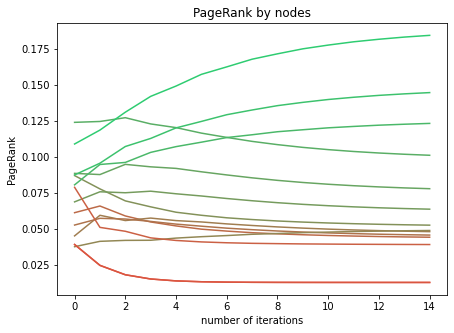

In [154]:
plt.figure(figsize=(7, 5))
for idx, node in enumerate(G.nodes):
    plt.plot(
        ranks[:, idx], 
        color=node_color(idx, ranks[-1], start_rgb, end_rgb)
    )
plt.xlabel('number of iterations')
plt.ylabel('PageRank')
plt.title('PageRank by nodes')
plt.show()

Next, let us see another visualization of PageRank dynamics. Here are nodes on x axis and PageRank on y axis.

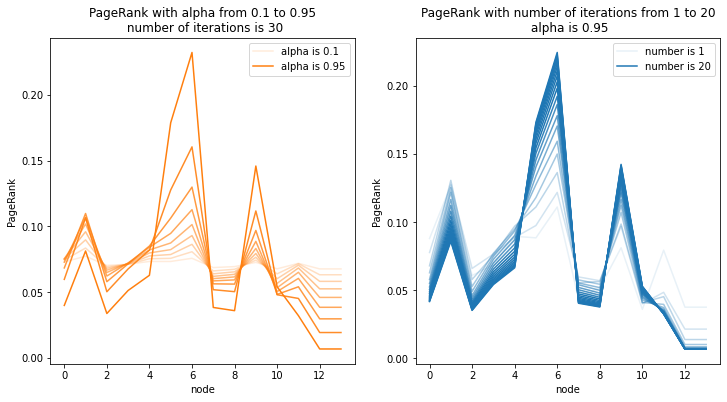

In [155]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
artists = []
for alpha in np.linspace(0.1, 0.95, 9):
    artists.append(plt.plot(page_rank(G, alpha, 30), alpha=alpha+0.05, c='tab:orange')[0])
plt.title('PageRank with alpha from 0.1 to 0.95\n number of iterations is 30')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.legend([artists[0], artists[-1]], ['alpha is 0.1', 'alpha is 0.95'])

plt.subplot(1, 2, 2)
artists = []
for i in np.arange(1, 20):
    artists.append(plt.plot(page_rank(G, 0.95, i), alpha=min(i*0.1, 1), c='tab:blue')[0])
plt.title('PageRank with number of iterations from 1 to 20\n alpha is 0.95')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.legend([artists[0], artists[-1]], ['number is 1', 'number is 20'])

plt.show()

Finally, let us check that PageRank converges to degree centrality in an undirected graph.

Write a function `rank_degree_scatter` that takes a graph `G`, `alpha` and number of iterations `k` and returns a scatter plot (`matplotlib.collections.PathCollection` object). The function draws a scatter plot with PageRank on x axis and degree centrality on y axis.

In [156]:
def rank_degree_scatter(G, alpha, k):
    ### BEGIN SOLUTION
    pr = [rank for node, rank in nx.pagerank(G, alpha, max_iter=k).items()]
    return plt.scatter(pr, nx.degree_centrality(G).values())
    ### END SOLUTION

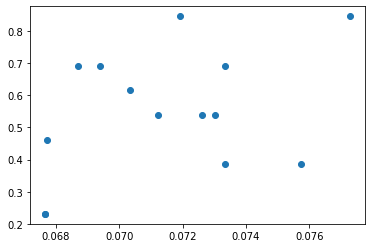

In [157]:
scatter = rank_degree_scatter(G, 0.1, 30)
sc_data = scatter.get_offsets().data
assert sc_data.shape == (14, 2)
assert 0.35 < np.corrcoef(sc_data[:, 0], sc_data[:, 1])[0, 1] < 0.42
assert 0.05 < sc_data[:, 0].min() < sc_data[:, 0].max() < 0.08
assert 0.01 < sc_data[:, 1].min() < sc_data[:, 1].max() < 0.9

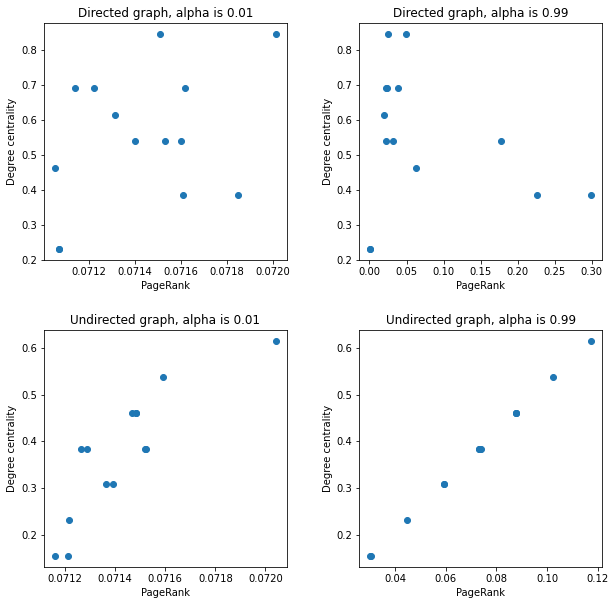

In [158]:
plt.figure(figsize=(10, 10))

cases = [
    [0.01, G, 'Directed'],
    [0.99, G, 'Directed'],
    [0.01, nx.Graph(G), 'Undirected'],
    [0.99, nx.Graph(G), 'Undirected'],
]

for i, (alpha, graph, graph_type) in enumerate(cases):
    plt.subplot(2, 2, i+1)
    scatter = rank_degree_scatter(graph, alpha, 100)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.xlabel('PageRank')
    plt.ylabel('Degree centrality')
    plt.title(f'{graph_type} graph, alpha is {alpha}')
plt.show()

### Task 4. HITS visualization (2 points)

In this task we will try to find authorities and hubs in political blogs and visualize them. The data is provided from [Political blogosphere Feb. 2005](http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm) dataset.

The graph contains parallel edges, but HITS algorithm only works without parallel edges. The simplest way to drop parallel edges is to convert a directed multigraph (`nx.MultiDiGraph`) into a directed graph (`nx.DiGraph`).

Write a function `hits_polblogs` that takes a path to a gml file with data and returns a tuple with a graph and two dictionaries of the form
* `{node: value}`

The first dictionary is hub scores, the second one is authority scores. That is, a full output is `(G, hub, auth)`. Apply `nx.hits` to calculate hub and authority scores.

In [168]:
def hits_polblogs(filename):
    G = nx.read_gml(filename)
    G = nx.DiGraph(G)
    h, a = nx.hits(G)
    
    return G, h, a 

In [169]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/polblogs.gml'
open('polblogs.gml', 'wb').write(requests.get(url).content)
G, hub, auth = hits_polblogs('polblogs.gml')
assert type(G) == nx.DiGraph
assert len(hub.values()) == len(auth.values()) == 1490
assert round(max(hub.values()), 4) == 0.0069
assert round(max(auth.values()), 4) == 0.015

In [170]:
G.number_of_nodes()

1490

In [171]:
G.number_of_edges()

19025

There are many edges and nodes and it makes hard to draw the whole graph. Then, let us draw a scatter plot with hub and authority scores.

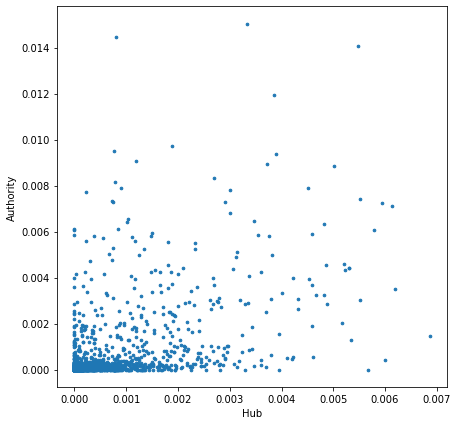

In [172]:
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel('Hub')
plt.ylabel('Authority')
plt.show()

Next, draw a graph with 14 nodes: top 7 authorities and top 7 hubs. Hubs will be on the left, authorities will be on the right.

Write a function `hits_visualization` that takes a graph `G`, hub, authority dictionaries, the number of top nodes and returns a dictionary with keys:
* `h_top` — np.array of top nodes by hub score
* `a_top` — np.array of top nodes by authority score
* `subG` — subgraph of `G` with top nodes only
* `h_vals` — np.array with hub scores (in initial graph) of top nodes that ordered by `subG.nodes` view 
* `a_vals` — the same for authority score
* `pos` — dictionary with keys are nodes and values are x-y positions of the form

`{node: [x, y]}` where 
* x equals to 0 if it is a hub and 1 if it is a authority
* y equals to an index of top array

That is, x could be 0 or 1 and y could be 0, 1, ..., 6.

In [216]:
def hits_visualization(G, hub, auth, top):
    hub_sorted = sorted(hub.items(), key=lambda x: x[1], reverse=True)[:7]
    h_top = list(map(lambda x: x[0], hub_sorted))

    auth_sorted = sorted(auth.items(), key=lambda x: x[1], reverse=True)[:7]
    a_top = list(map(lambda x: x[0], auth_sorted))

    subG = G.subgraph(h_top + a_top)

    h_vals = []
    a_vals = []
    pos = {}

    for node in subG.nodes:
        h_vals.append(hub[node])
        a_vals.append(auth[node])
        if node in h_top: 
            x = 0 
            y = h_top.index(node)
        else: 
            x = 1
            y = a_top.index(node)

        pos[node] = [x, y]

    return {'h_top': np.array(h_top), 'a_top': np.array(a_top), 'subG': subG, 'h_vals': np.array(h_vals),'a_vals': np.array(a_vals), 'pos': pos}



In [217]:
vi = hits_visualization(G, hub, auth, 7)
h_top, a_top = vi['h_top'], vi['a_top']
h_vals, a_vals = vi['h_vals'], vi['a_vals']
subG, pos = vi['subG'], vi['pos']
assert h_top.shape[0] == a_top.shape[0] == int(len(subG) / 2) == 7
assert 'politicalstrategy.org' == h_top[0]
assert 'talkingpointsmemo.com' in a_top
assert h_vals.shape == a_vals.shape == (14,)
assert h_vals.max() < 0.0069
assert 0 <= a_vals.min()
assert pos['atrios.blogspot.com'] == [1, 2]
assert pos['juancole.com'] == [1, 5]

Networkx allows to draw nodes, edges, labels separately. In this case, we need to fix a layout and then draw a graph by layers. Let us draw a graph via `nx.draw_networkx`, then draw right labels and then draw left labels via `nx.draw_networkx_labels`. Also we will crop labels with more than 15 symbols to fit on the screen.

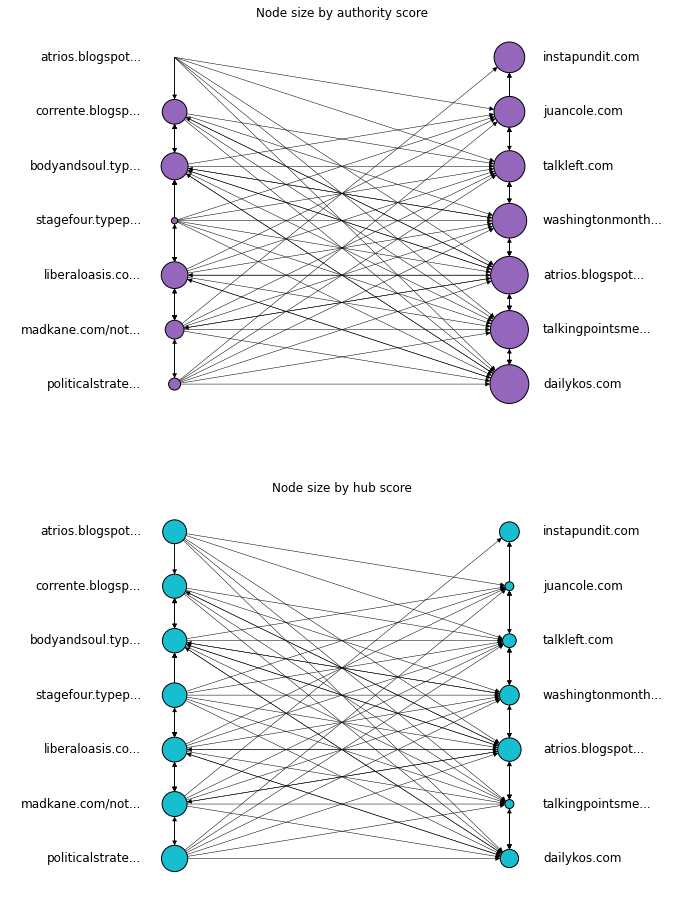

In [218]:
plt.figure(figsize=(12, 8*2))

h_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in h_top}
a_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in a_top}
a_pos = {node:(pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node:(pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, 'tab:purple', a_vals, 'Node size by authority score'], 
         [2, 'tab:cyan', h_vals, 'Node size by hub score']]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis('off')
    nx.draw_networkx(
        subG,
        pos,
        width=0.5,
        with_labels=False,
        edgecolors='black',
        node_size=vals*1e5,
        node_color=color
    )
    nx.draw_networkx_labels(
        subG,
        pos=a_pos,
        labels=a_labels,
        horizontalalignment='left'
    )
    nx.draw_networkx_labels(
        subG,
        pos=h_pos,
        labels=h_labels,
        horizontalalignment='right'
    )

    plt.xlim(-0.5, 1.5)
    plt.title(t)

### Task 5. Node similarity (1 points)

In this section we will look at how nodes can be similar to each other. We will consider the movie co-watch dataset. The dataset is built based on the MovieLens-100k data. The films have links between when one user gives them the highest rate and watch both.

In [221]:
url = "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/movies.gml"
open('movie-cowatch.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('movie-cowatch.gml')
G = nx.convert_node_labels_to_integers(G)

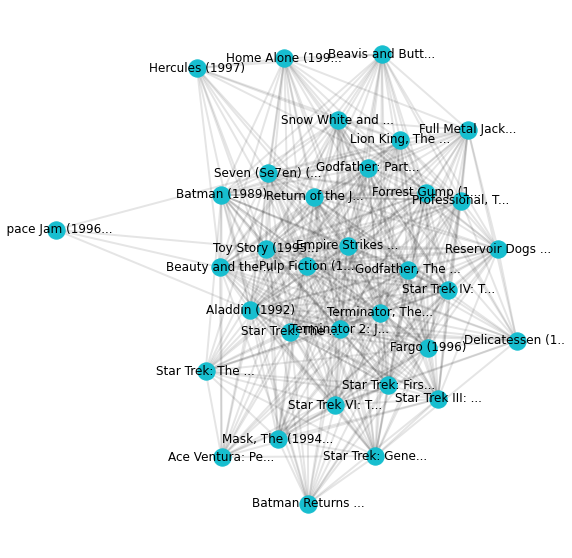

In [222]:
labs = nx.get_node_attributes(G, "movieName")
labs = {i:labs[i][:15] if len(labs[i])<=15 else labs[i][:15] + '...' for i in labs}
plt.figure(figsize=(10, 10))
plt.gca().axis('off')

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='tab:cyan'
)
nx.draw_networkx_edges(
    G,
    pos,
    width=2,
    alpha=0.1,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels=labs
)
plt.show()

Write a function `sim_values` that takes an adjacency matrix, node indices and returns a tuple with similarity values:
* Pearson correlation $$r(i,j) = \frac{\text{cov}(A_i, A_j)}{\sigma_i \sigma_j}$$
* Jaccard similarity $$J(i, j) = \frac{|\mathcal{N}(i) \cap \mathcal{N}(j)|}{|\mathcal{N}(i) \cup \mathcal{N}(j)|}$$
* Cosine similarity $$\cos(i,j) = \frac{A_i^\top A_j}{|A_i||A_j|}$$

In [223]:
from sklearn.metrics import jaccard_score
from scipy.stats import pearsonr

In [235]:
def sim_values(A, i, j):
    # r = np.cov(A[i,:], A[j,:]) / (np.std(A[i,:]) * np.std(A[j,:]))
    r = pearsonr(A[i,:], A[j,:])[0]
    J = jaccard_score(A[i,:], A[j,:])
    cos = A[i,:].T @ A[j,:] / (np.linalg.norm(A[i,:]) *  np.linalg.norm(A[j,:]))
    
    return r, J, cos 

In [237]:
A = nx.to_numpy_array(G)
cos_sim = np.zeros(A.shape)
pearson_sim = np.zeros(A.shape)
jaccard_sim = np.zeros(A.shape)
for i in range(len(G)):
    for j in range(i, (len(G))):
        pval, jval, cval = sim_values(A, i, j)
        pearson_sim[i, j] = pval
        pearson_sim[j, i] = pval
        jaccard_sim[i, j] = jval
        jaccard_sim[j, i] = jval
        cos_sim[i, j] = cval
        cos_sim[j, i] = cval
assert A.shape == pearson_sim.shape == jaccard_sim.shape == cos_sim.shape == (34,34)
assert pearson_sim[0].sum().round(4) == -2.5541
assert jaccard_sim[1].sum().round(4) == 24.2374
assert cos_sim[0].sum().round(4) == 28.4601

Let us draw heatmaps of these similarities.

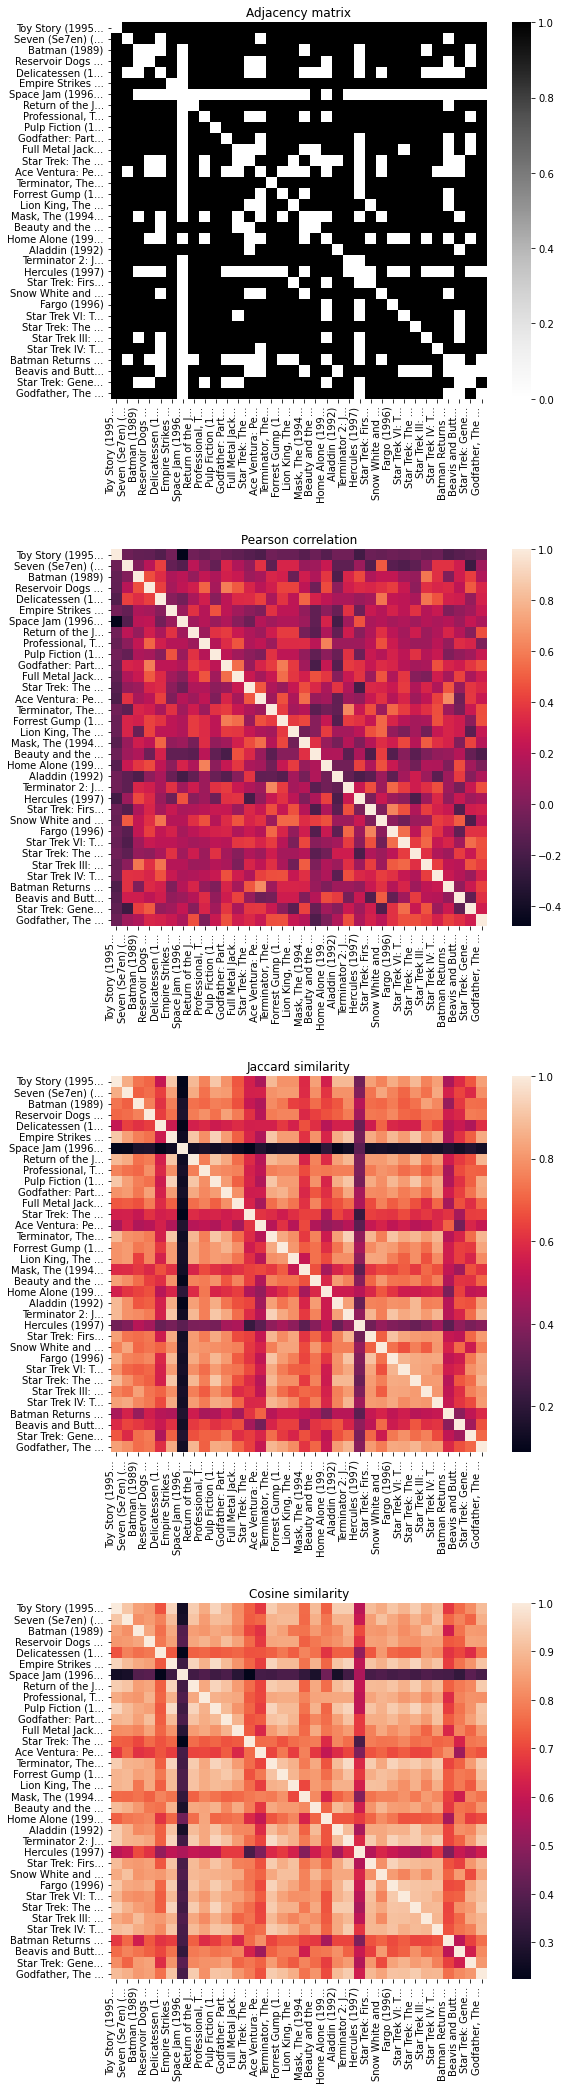

In [238]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, pearson_sim, None, 'Pearson correlation'], 
         [3, jaccard_sim, None, 'Jaccard similarity'], 
         [4, cos_sim, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[labs.get(i) for i in G.nodes])
    hmap.set_xticklabels(
        labels=[labs.get(i) for i in G.nodes], 
        horizontalalignment='right')
    plt.title(t)

### Task 6. Cuthill-McKee reordering (0 points)

Without special preprocess procedures an adjacency matrix can look very noisy and hide network's structure. There are some procedures of node reordering that provides a better view of the network's adjacency matrix. Reverse Cuthill-McKee finds permutation of the nodes that minimizes the bandwidth of the matrix, which is calculated as

$$ \theta = \max_{a_{ij} > 0}|i-j|$$

Unformally, this algorithm puts some mass on the diagonal of adjacency matrix. 

Write a function `cm_order` that takes a graph and returns a np.array with a permutation of the form $[i_1, i_2, \dots, i_n]$ where $i_1$ is an index of the first row and the first column.

Apply `scipy.sparse.csgraph.reverse_cuthill_mckee` or `nx.utils.reverse_cuthill_mckee_ordering`.

In [239]:
def cm_order(G):
    ### BEGIN SOLUTION
    A = nx.to_numpy_array(G)
    return reverse_cuthill_mckee(csr_matrix(A), symmetric_mode=True)
    ### END SOLUTION

In [240]:
order = cm_order(G)
assert order.shape == (34,)
assert order[4:6].sum() < order[:3].sum() < order[4:7].sum()

Let us draw the heatmaps with a default and changed order side-by-side. A default order will be on the left, a changed order — on the right.

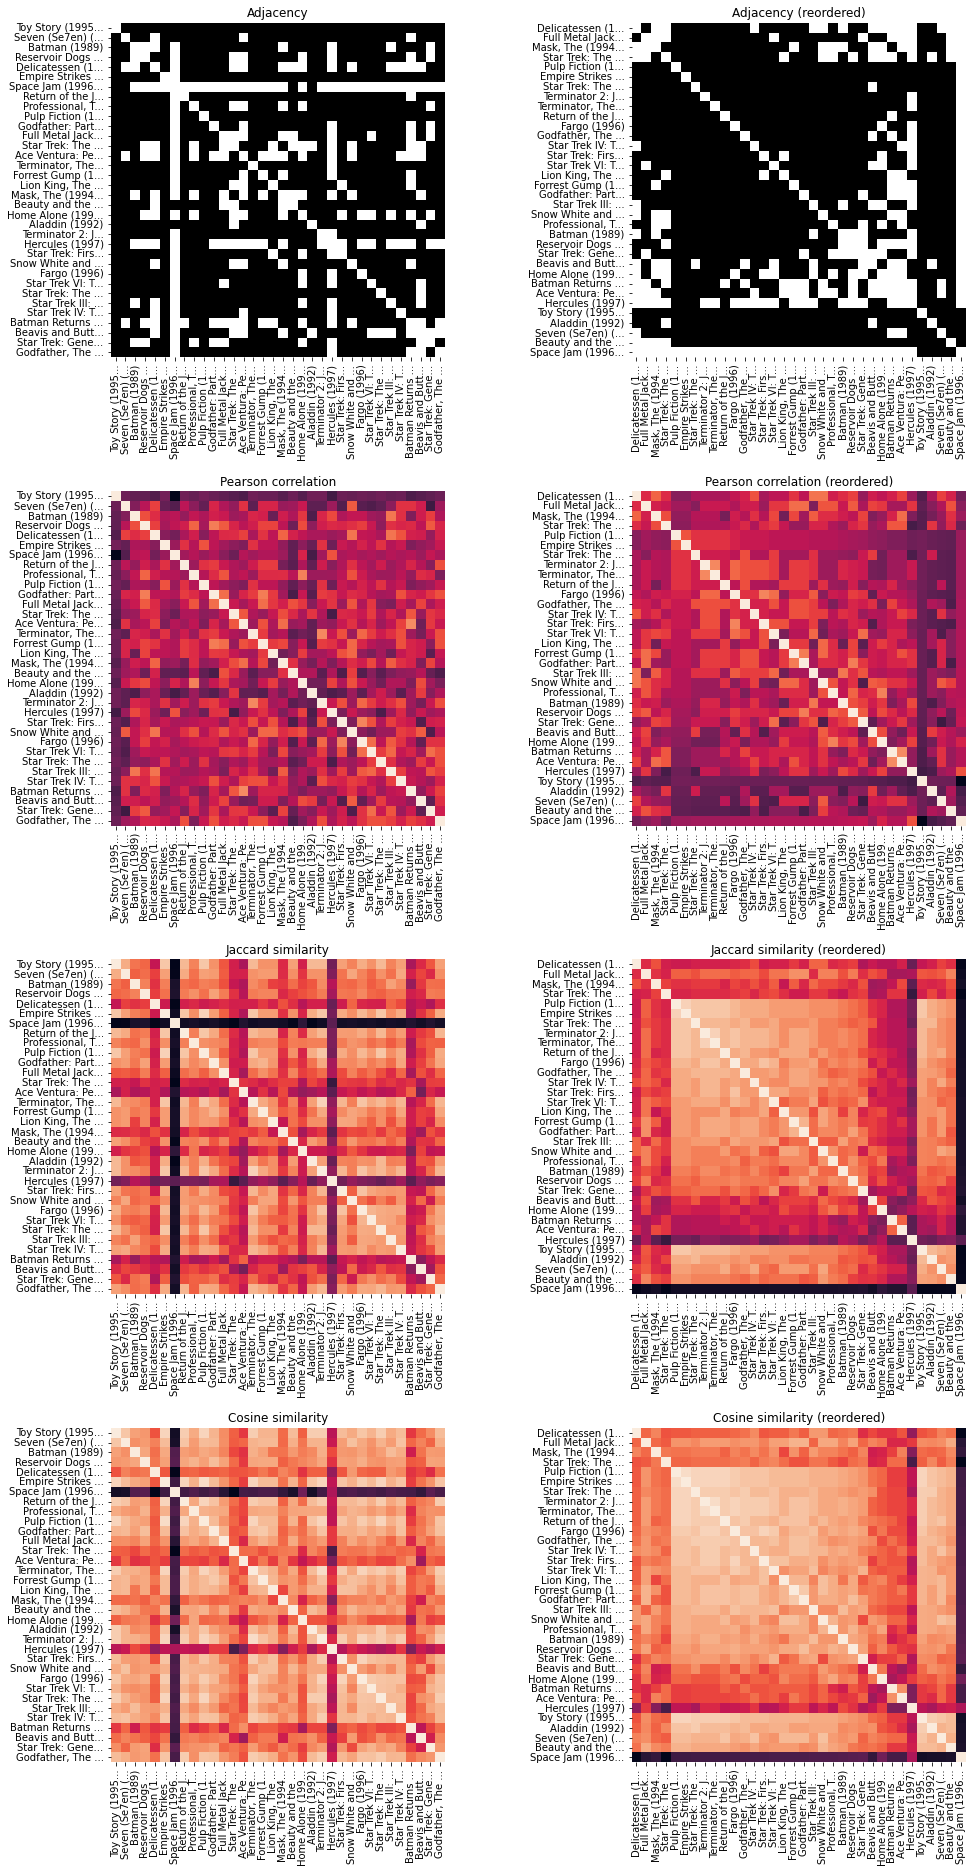

In [241]:
fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(34)],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, pearson_sim, None, 'Pearson correlation', range(34)], 
         [4, pearson_sim, None, 'Pearson correlation (reordered)', order], 
         [5, jaccard_sim, None, 'Jaccard similarity', range(34)], 
         [6, jaccard_sim, None, 'Jaccard similarity (reordered)', order], 
         [7, cos_sim, None, 'Cosine similarity', range(34)], 
         [8, cos_sim, None, 'Cosine similarity (reordered)', order]]

newLabs = np.array([labs.get(i) for i in G.nodes])

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
        yticklabels=newLabs[o])
    hmap.set_xticklabels(
        labels=newLabs[o], 
        rotation=90)
    plt.title(t)

We can observe that the right-hand heatmaps look smoother, and we can detect dense regions on them.

### Task 7. Assortative mixing (1 points)

Consider the network representing the timetable of American college football games during season Fall 2000, in which vertices represent universities and colleges, and edges represent regular season games between teams during the year in question. Colleges are grouped into “conferences,” which are defined primarily by geography, and teams normally play more often against other teams in their own conference than they do against teams from other conferences. Let us check that by drawing assortative mixing matrix $E$ where $e_{ij}$ is a fraction of edges that connect nodes of the type $i$ with nodes of the type $j$.

In [243]:
url = "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/footballG.gml"
open('footballG.gml', 'wb').write(requests.get(url).content)
footballG = nx.read_gml('footballG.gml', destringizer=int)
footballG.nodes[0]

{'name': 'BrighamYoung', 'conference': 'H'}

Write a function `conferences_mixing_matrix` that takes a graph `G` and a dictionary with mapping of the form `{conference: row/column index}` and returns a np.array of assortative mixing matrix of a `conference` attribute.

In [298]:
def count_edges(G, d, conf1, conf2):
    count = 0
    for node_num1 in d[conf1]:
        for node_num2 in d[conf2]:
            if (node_num1, node_num2) in G.edges():
                count += 1 
    return count 



def conferences_mixing_matrix(footballG, mapping):
    conf_set = set() 
    for node_num in footballG.nodes:
        conf_set.add(footballG.nodes[node_num]["conference"])

    d = {conf: [] for conf in conf_set} 

    for node_num in footballG.nodes:
        d[footballG.nodes[node_num]["conference"]].append(node_num)

    n = len(conf_set)
    matrix = np.zeros((n, n))

    num_edges = len(footballG.edges)

    for conf1 in conf_set:
        for conf2 in conf_set: 
            row_index, column_index = mapping[conf1], mapping[conf2]
            matrix[row_index, column_index] = count_edges(footballG, d, conf1, conf2) / (2 * num_edges)
    
    return matrix
            



In [299]:
conf_values = np.random.permutation(
    np.unique([footballG.nodes[n]['conference'] for n in footballG.nodes])
)
mapping = {val: i for i, val in enumerate(conf_values)} 
mixing = conferences_mixing_matrix(footballG, mapping)
assert mixing.shape == (19, 19)
assert mixing.max() < 0.09
assert mixing.min() == 0
assert round(mixing[mapping['A'], mapping['B']], 4) == 0.0041

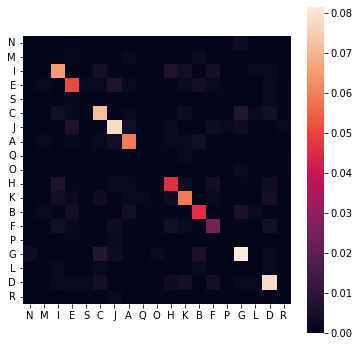

In [300]:
fig = plt.figure(figsize=(6, 6))
hmap = sns.heatmap(
    mixing,
    cbar=True,
    square=True)
hmap.set_xticklabels([m for m in mapping])
hmap.set_yticklabels([m for m in mapping], rotation=0)
plt.show()

To quantify the level of assortative mixing in a network we define an assortativity coefficient

$$r=\frac{\operatorname{Tr} E-\|E^{2}\|}{1-\|E^{2}\|}$$

where $\|x\|$ is a sum of all elements of the matrix $x$. This formula gives $r = 0$ when there is no assortative mixing, and $r = 1$ when there is perfect assortative mixing and $\text{Tr} E = 1$. If the network is perfectly disassortative, i.e., every edge connects two vertices of different types, then $r$ is negative and lies in general in the range $−1 \leq r < 0$.

Write a function `assortativity_coef` that takes a mixing matrix and returns an assortativity coefficient.

In [295]:
def assortativity_coef(mixing):
    ### BEGIN SOLUTION
    num = np.diag(mixing).sum() - (mixing @ mixing).sum()
    den = 1 - (mixing @ mixing).sum()
    return num / den
    ### END SOLUTION

In [296]:
assert assortativity_coef(np.eye(5) / 5) == 1
assert assortativity_coef(np.ones((5, 5)) / 25) == 0
_mixing = np.ones((2, 2)) - np.diag(np.ones(2))
assert assortativity_coef(_mixing / _mixing.sum()) == -1

In [297]:
print(f'Assortativity coefficient: {assortativity_coef(mixing):.4f}')

Assortativity coefficient: 0.6275


We find a large value for the assortativity coefficient, indicating strong assortative mixing, i.e., colleges do indeed play games with their conference partners to a substantially greater degree than one would expect in a randomly mixed network.